In [ ]:
from google.colab import files
#files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vedantsinhmahida","key":"69f2b5b6fc39937851294920466e8cde"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 99% 223M/225M [00:06<00:00, 40.3MB/s]
100% 225M/225M [00:06<00:00, 35.8MB/s]


In [ ]:
!unzip flowers-recognition.zip -d flowers_dataset

Archive:  flowers-recognition.zip
  inflating: flowers_dataset/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers_dataset/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers_dataset/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers_dataset/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers_dataset/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers_dataset/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers_dataset/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers_dataset/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers_dataset/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers_dataset/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers_dataset/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers_dataset/flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers_dataset/flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers_

## **Prepare and Explore Data**

In [ ]:
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

**Create Image and Label DataFrame**

In [ ]:
def create_image_df(img_dir):
  """
  Create a DataFrame containing file paths and labels for images in a directory.
  """
  img_dir = Path(img_dir)
  img_paths = list(img_dir.glob("**/*.jpg"))

  # Extract labels based on folder names
  labels = []
  for path in img_paths:
    label = os.path.split(os.path.split(path)[0])[1]
    labels.append(label)

  # Create a DataFrame with file paths and labels
  filepaths = pd.Series([str(p) for p in img_paths], name='fp')
  labels = pd.Series(labels, name='label')
  image_df = pd.concat([filepaths, labels], axis=1)
  # Shuffle df and reset index
  image_df = image_df.sample(frac=1).reset_index(drop=True)

  return image_df

In [ ]:
##### CONSTANTS #####
IMG_DIR = "flowers_dataset/flowers"
TEST_SIZE = 0.2
SEED = 42

In [ ]:
img_df = create_image_df(IMG_DIR)

img_df.head()

,fp,label
0,flowers_dataset/flowers/tulip/19915714271_3d8d...,tulip
1,flowers_dataset/flowers/daisy/3098641292_76c90...,daisy
2,flowers_dataset/flowers/rose/4979895172_ca06eb...,rose
3,flowers_dataset/flowers/dandelion/16462263826_...,dandelion
4,flowers_dataset/flowers/rose/5088766459_f81f50...,rose


In [ ]:
img_df.shape

(4317, 2)

**Visualize random samples from data**

In [ ]:
def display_random_images(image_df, n=20):
  """
  Display a random images with their labels from the dataset.
  """
  # Choose n random samples
  sample_df = image_df.sample(n=n).reset_index(drop=True)

  # Calculate the grid size for plotting
  rows = int(n**0.5) + 1
  cols = int(n / rows) + (n % rows > 0)

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 7),
                            subplot_kw={'xticks': [], 'yticks': []})
  axes = axes.flatten()  # Flatten to easily iterate over axes

  for i in range(n):
    img = plt.imread(sample_df.fp[i])
    axes[i].imshow(img)
    axes[i].set_title(sample_df.label[i])

  # Hide any extra subplots if n does not fill the grid completely
  for j in range(n, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

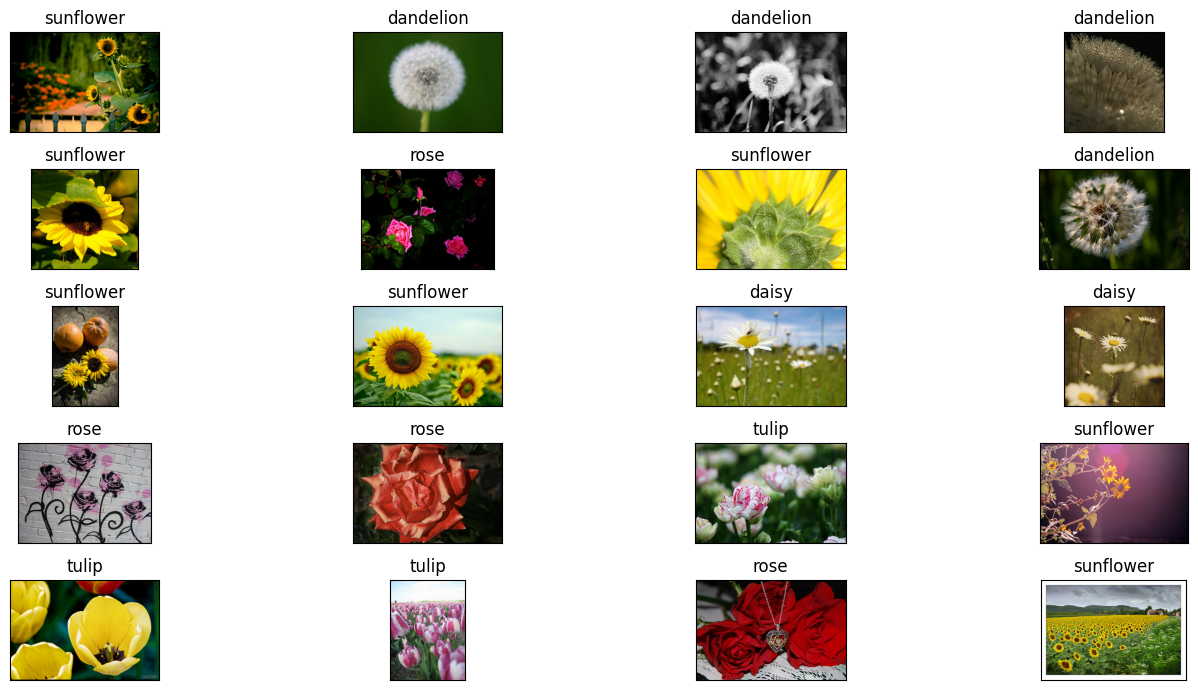

In [ ]:
display_random_images(image_df=img_df, n=20)

### **Split data into train and test split**

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(img_df, test_size=TEST_SIZE, random_state=SEED)
train_df.shape, test_df.shape

((3453, 2), (864, 2))

In [ ]:
# Let's check class distribution in training data for imbalance

def plot_class_distribution(image_df, title):
  class_counts = img_df['label'].value_counts()
  # Plot the class distribution
  plt.figure(figsize=(10, 6))
  class_counts.plot(kind='barh', color='tomato')
  plt.xlabel('Number of Images')
  plt.ylabel('Class')
  plt.title(title)
  plt.gca().invert_yaxis()
  plt.show()

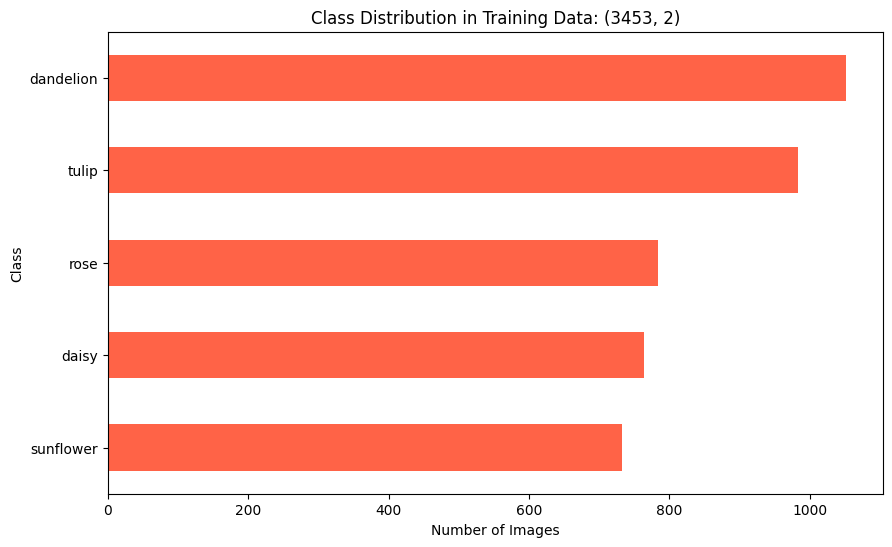

In [ ]:
plot_class_distribution(train_df, f"Class Distribution in Training Data: {train_df.shape}")

**Train and Test generator**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define data generators
train_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_data_gen, test_data_gen

(<keras.src.legacy.preprocessing.image.ImageDataGenerator at 0x7e0037d7ba30>,
 <keras.src.legacy.preprocessing.image.ImageDataGenerator at 0x7e0037eec190>)

**Train, Validation and Test Images From Generator**

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Training data generator
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='fp',  # Column name for file paths to images
    y_col='label',  # Column name for labels
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

# Validation data generator
val_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='fp',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test data generator
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='fp',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


## **Model Building**

**`ResNet50` Transfer Learning**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

NUM_CLASSES = 5

def get_model():
  # Get base model
  base_model = ResNet50(weights='imagenet', include_top=False)

  # Freeze the layers in base model
  for layer in base_model.layers:
    layer.trainable = False

  # Get base model output
  base_model_ouput = base_model.output

  # Adding our own layer
  x = GlobalAveragePooling2D()(base_model_ouput)
  # Adding fully connected layer
  x = Dense(512, activation='relu')(x)
  x = Dense(NUM_CLASSES, activation='softmax', name='fcnew')(x)

  model = Model(inputs=base_model.input, outputs=x)
  return model

In [ ]:
# Build model
model = get_model()

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Summary of model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train model
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  validation_data=val_generator,
  validation_steps=val_generator.samples // val_generator.batch_size,
  epochs=5
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 585ms/step - accuracy: 0.6406 - loss: 0.9375 - val_accuracy: 0.8393 - val_loss: 0.4493
Epoch 2/5
 1/86 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7500 - loss: 0.5261

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7500 - loss: 0.5261 - val_accuracy: 0.7778 - val_loss: 0.4683
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 495ms/step - accuracy: 0.8869 - loss: 0.3402 - val_accuracy: 0.8527 - val_loss: 0.3900
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.3778 - val_accuracy: 0.8889 - val_loss: 0.4264
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 485ms/step - accuracy: 0.9091 - loss: 0.2934 - val_accuracy: 0.8958 - val_loss: 0.3297


In [ ]:
def plot_training_history(history):
  """
  Plots the training and validation accuracy and loss over epochs.
  """
  # Extract accuracy and loss
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # Plot training & validation accuracy
  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Assess overfitting, underfitting, or good fit
  if val_acc[-1] < 0.7 and acc[-1] < 0.7:
    print("The model is underfitting. Both training and validation accuracy are low.")
  elif acc[-1] - val_acc[-1] > 0.1 and val_loss[-1] > loss[-1]:
    print("The model is overfitting. Training accuracy is much higher than validation accuracy, "
          "and validation loss is higher than training loss.")
  elif abs(acc[-1] - val_acc[-1]) <= 0.1:
    print("The model has a good fit. Training and validation accuracy are close.")
  else:
    print("The model's performance needs further investigation. Check the training and validation trends.")

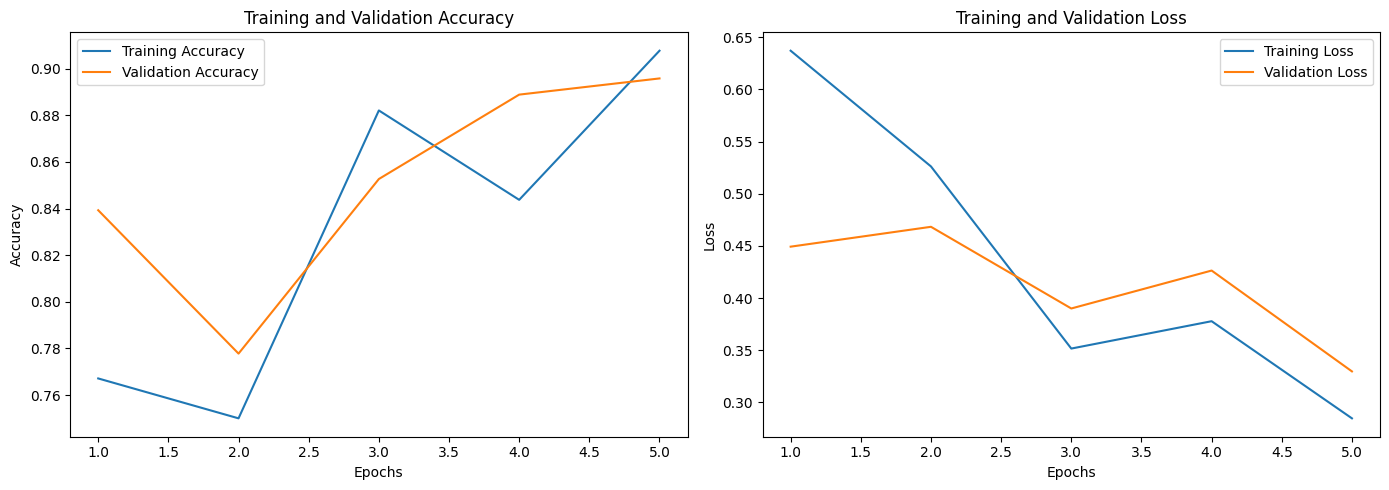

The model has a good fit. Training and validation accuracy are close.


In [ ]:
plot_training_history(history)

## **Finetuning transfer learning model**

In [ ]:
from tensorflow.keras import layers, optimizers

epochs = 10
split_at = 140

for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Choosing lower learning rate for fine-tuning
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train model
history_1 = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  validation_data=val_generator,
  validation_steps=val_generator.samples // val_generator.batch_size,
  epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 72s 603ms/step - accuracy: 0.8896 - loss: 0.3745 - val_accuracy: 0.8899 - val_loss: 0.3363
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9062 - loss: 0.2691 - val_accuracy: 1.0000 - val_loss: 0.1145
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 485ms/step - accuracy: 0.9442 - loss: 0.2080 - val_accuracy: 0.9048 - val_loss: 0.3102
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2702 - val_accuracy: 0.9444 - val_loss: 0.1179
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.9571 - loss: 0.1475 - val_accuracy: 0.9018 - val_loss: 0.2966
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.9375 - loss: 0.2051 - val_accuracy: 0.9444 - val_loss: 0.2303
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 488ms/step - accuracy: 0.9739 - loss: 0.0995 - val_accuracy: 0.9122 - val_loss: 0.2603
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9688 - loss: 0.0620 - val_accuracy: 0.

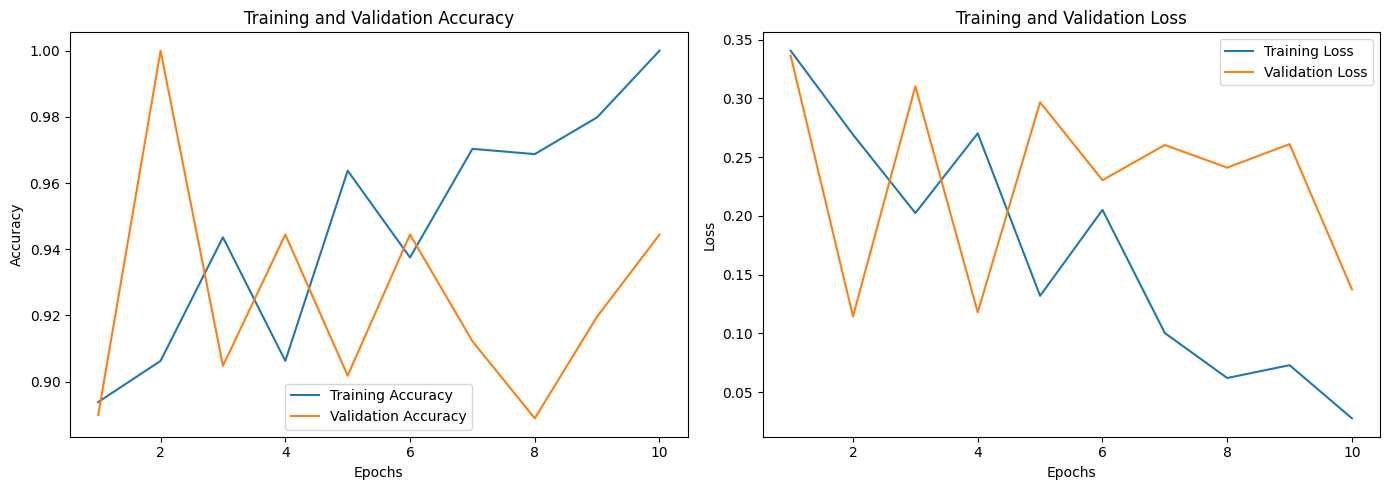

The model has a good fit. Training and validation accuracy are close.


In [ ]:
plot_training_history(history_1)

**`EfficientNet` model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model, optimizers

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 5

# Load EfficientNetB0 Pretrained Model
base_model = EfficientNetB0(
  weights='imagenet',
  include_top=False,
  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze all layers except last
for layer in base_model.layers[:-20]:
  layer.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 1,680,181 (6.41 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
# Compile the model
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history_2 = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
  validation_data=val_generator,
  validation_steps=val_generator.samples // val_generator.batch_size,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 717ms/step - accuracy: 0.4105 - loss: 5.6856 - val_accuracy: 0.8140 - val_loss: 4.5744 - learning_rate: 1.0000e-04
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.6562 - loss: 5.0584 - val_accuracy: 0.8889 - val_loss: 4.3254 - learning_rate: 1.0000e-04
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 100s 478ms/step - accuracy: 0.8029 - loss: 4.5121 - val_accuracy: 0.8705 - val_loss: 3.9559 - learning_rate: 1.0000e-04
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 4.0449 - val_accuracy: 0.8333 - val_loss: 4.0512 - learning_rate: 1.0000e-04
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 79s 459ms/step - accuracy: 0.8418 - loss: 3.8952 - val_accuracy: 0.8839 - val_loss: 3.4798 - learning_rate: 1.0000e-04
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.9062 - loss: 3.4356 - val_accuracy: 0.8333 - val_loss: 3.8150 - learning_rate: 1.0000e-04
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy

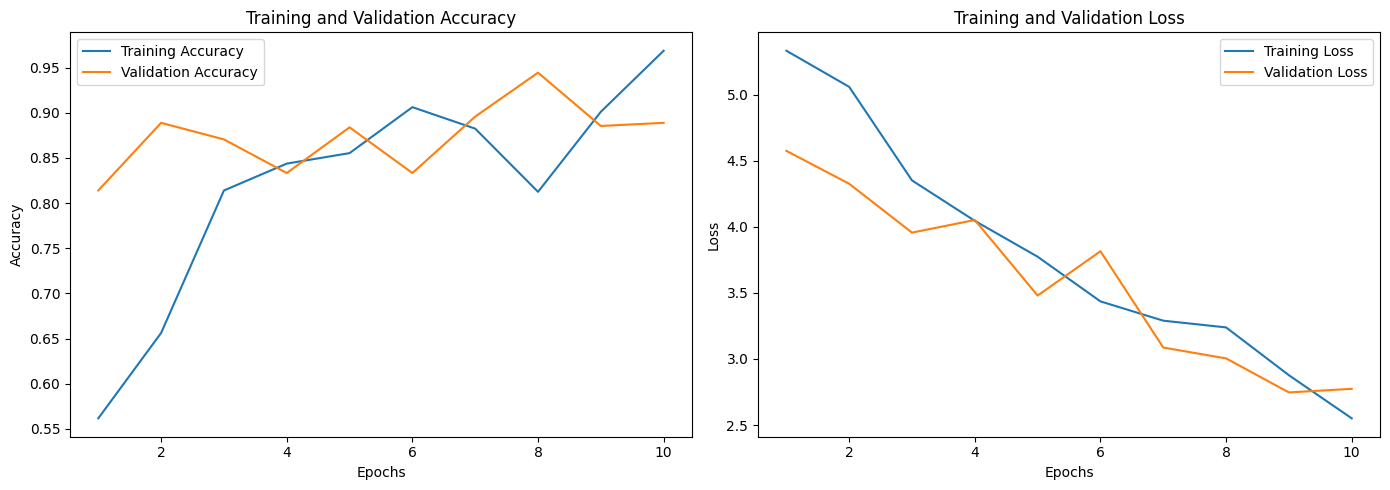

The model has a good fit. Training and validation accuracy are close.


In [ ]:
plot_training_history(history_2)

## **Make Predictions**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_with_test_generator(model, test_generator, num_samples=5):
  """
  Predicts on the test set using a generator and visualizes a few samples.
  """
  # Make predictions on the test set
  predictions = model.predict(test_generator)
  predicted_classes = np.argmax(predictions, axis=1)

  # Get true labels
  true_classes = test_generator.classes
  class_indices = {v: k for k, v in test_generator.class_indices.items()}  # Reverse mapping

  # Visualize random samples
  for i in range(num_samples):
      idx = np.random.randint(len(test_generator.filenames))  # Random sample index
      img_path = test_generator.filepaths[idx]  # Image path
      img = plt.imread(img_path)  # Read image for display
      true_label = class_indices[true_classes[idx]]  # True label
      predicted_label = class_indices[predicted_classes[idx]]  # Predicted label
      confidence = predictions[idx][predicted_classes[idx]]  # Confidence score

      # Plot the image with prediction and true label
      plt.figure(figsize=(5, 5))
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"True: {true_label} | Predicted: {predicted_label} ({confidence:.2f})")
      plt.show()

  return predicted_classes

In [ ]:
class_indices = train_generator.class_indices
class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


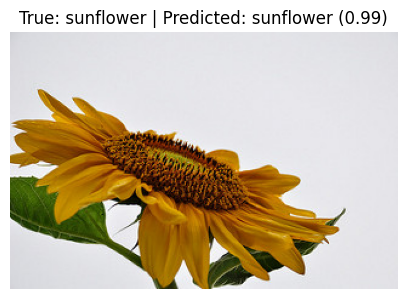

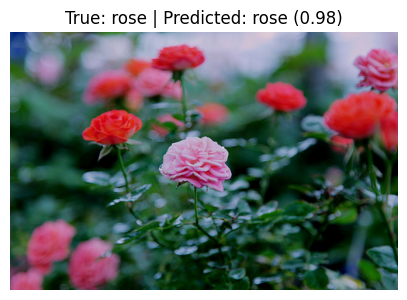

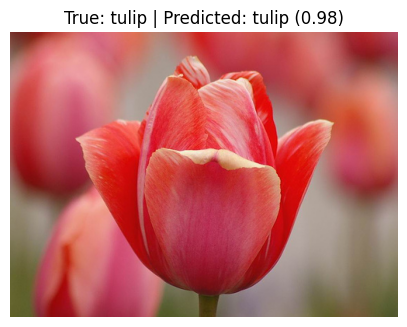

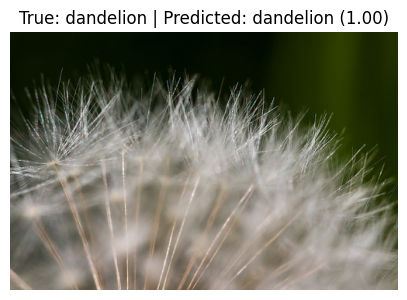

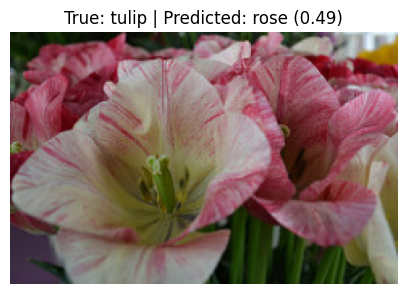

array([3, 1, 3, 1, 4, 2, 1, 4, 1, 2, 1, 0, 2, 3, 0, 2, 2, 4, 1, 2, 3, 4,
       1, 1, 0, 3, 3, 4, 3, 1, 0, 4, 2, 1, 2, 1, 4, 0, 3, 1, 1, 0, 0, 4,
       0, 1, 2, 2, 0, 4, 1, 3, 4, 0, 4, 1, 2, 1, 2, 1, 0, 1, 3, 4, 0, 4,
       3, 1, 0, 2, 2, 3, 4, 1, 4, 3, 0, 0, 0, 0, 4, 1, 4, 0, 4, 2, 0, 2,
       1, 1, 3, 2, 1, 3, 0, 2, 1, 1, 0, 4, 2, 2, 4, 2, 1, 0, 3, 1, 1, 1,
       0, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 3, 1, 3, 0, 4, 0, 4, 3, 1, 3, 4,
       1, 2, 1, 2, 4, 2, 0, 3, 2, 4, 3, 2, 2, 4, 3, 2, 0, 1, 1, 4, 1, 1,
       4, 2, 2, 1, 4, 0, 3, 1, 4, 1, 4, 2, 2, 0, 4, 4, 2, 4, 4, 2, 1, 0,
       1, 4, 1, 2, 4, 2, 1, 3, 1, 3, 3, 0, 1, 4, 0, 1, 4, 3, 1, 0, 1, 0,
       0, 1, 2, 4, 3, 4, 1, 4, 2, 2, 4, 4, 3, 4, 1, 0, 1, 0, 3, 3, 2, 2,
       3, 1, 1, 4, 1, 0, 1, 4, 3, 0, 2, 0, 2, 0, 0, 2, 1, 3, 1, 0, 2, 2,
       2, 3, 0, 1, 2, 2, 1, 4, 4, 4, 0, 4, 2, 3, 4, 2, 2, 0, 2, 4, 2, 1,
       0, 4, 1, 0, 1, 4, 3, 3, 3, 0, 1, 4, 1, 2, 2, 4, 2, 0, 4, 3, 0, 3,
       0, 3, 1, 3, 1, 3, 1, 3, 0, 4, 2, 3, 1, 1, 2,

In [ ]:
predictions = predict_with_test_generator(model, test_generator, num_samples=5)
predictions

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, accuracy_score

true_classes = test_generator.classes
predicted_classes = predict_with_test_generator(model, test_generator, num_samples=0)

print(f"Accuracy: {accuracy_score(true_classes, predicted_classes):.2f}")
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step
Accuracy: 0.88
              precision    recall  f1-score   support

       daisy       0.86      0.85      0.85       142
   dandelion       0.91      0.93      0.92       209
        rose       0.83      0.88      0.85       163
   sunflower       0.90      0.88      0.89       137
       tulip       0.90      0.85      0.88       213

    accuracy                           0.88       864
   macro avg       0.88      0.88      0.88       864
weighted avg       0.88      0.88      0.88       864

